### IMPORT

In [1088]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

### READING AND CLEANING

In [1099]:
def Cleaning_function(path):
    
    df = pd.read_csv(path)
    
    df.loc[df.hauteurarbre == 'de 10 m à 20 m', 'hauteurarbre'] = 15
    df.loc[df.hauteurarbre == 'Moins de 10 m', 'hauteurarbre'] = 5
    df.loc[df.hauteurarbre == 'Plus de 20 m','hauteurarbre'] = 25
    df[['lat', 'long']] = df.geo_point_2d.str.split(",", expand = True).astype(float)
    
    to_drop = ['intituleprotectionplu','typeimplantationplu','traitementchenilles','collectivite','genre','genre_desc','categorie','categorie_desc',
           'equipe','courrier','identifiantplu','identifiantplu','anneeabattage','essouchement','diametrearbre','causeabattage','remarques','raisondeplantation',
           'variete','stationmetro','structure','forme','typenature','portarbre','geo_point_2d']
    
    df_res = df.dropna(subset='anneedeplantation', inplace=True)
    df_res = df.drop(columns = to_drop)
    
    df_res.sous_categorie = df_res.sous_categorie.str[3:].astype('int64')
    df_res.code_parent = df_res.code_parent.str[3:].astype('int64')
    df_res.bien_reference = df_res.bien_reference.str[2:].astype('int64')
    df_res.code = df_res.code.str[3:].astype('int64')
    df_res.nom = df_res.nom.str[2:].astype('int64')

    imputer = SimpleImputer(strategy='median')
    
    df_res[['hauteurarbre']] = imputer.fit_transform(df_res[['hauteurarbre']])
    df_res.hauteurarbre.astype(int)
    
    le = LabelEncoder()
    df_res.sous_categorie_desc = le.fit_transform(df_res.sous_categorie_desc)
    df_res.stadededeveloppement = le.fit_transform(df_res.stadededeveloppement)
    
    
    df_res.to_pickle('C:/Users/eduard.vlasov/Documents/GitHub/ML/Data/cleaned_data_arbres.pkl')
    
    return df_res

In [1100]:
path = 'C:/Users/eduard.vlasov/Documents/GitHub/ML/Data/arbres_grenoble_epsg4326.csv'
df_res = Cleaning_function(path)

In [970]:
# sns.heatmap(df.isnull(), cbar=False)
# df.columns[df.isna().sum()>10000]
# df.loc[:, df.columns[df.isna().sum()>10000]].describe()

Index(['variete', 'equipe', 'remarques', 'raisondeplantation',
       'traitementchenilles', 'courrier', 'identifiantplu',
       'typeimplantationplu', 'intituleprotectionplu', 'anneeabattage',
       'essouchement', 'diametrearbre', 'causeabattage', 'stationmetro',
       'hauteurarbre', 'portarbre', 'forme', 'typenature'],
      dtype='object')

### VISIO

In [1105]:
#read cleaned csv
path='C:/Users/eduard.vlasov/Documents/GitHub/ML/Data/cleaned_data_arbres.pkl'
df_res = pd.read_pickle(path)

df_res.describe()

,elem_point_id,code,nom,sous_categorie,sous_categorie_desc,code_parent,adr_secteur,bien_reference,stadededeveloppement,anneedeplantation,hauteurarbre,lat,long
count,30144.00000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000,30144.000000
mean,19142.18186,20209.518976,20209.518976,158.107285,1.423799,2937.558386,3.828722,20209.518976,0.481787,1990.018644,12.773686,45.177280,5.727445
std,11824.16903,11164.956377,11164.956377,28.018516,0.695504,8408.419032,1.706830,11164.956377,0.870967,17.992314,5.575086,0.011999,0.012782
min,1.00000,1428.000000,1428.000000,65.000000,0.000000,7.000000,1.000000,1428.000000,0.000000,1900.000000,5.000000,45.151572,5.697915
25%,9180.75000,10667.750000,10667.750000,151.000000,1.000000,393.000000,2.000000,10667.750000,0.000000,1975.000000,5.000000,45.166299,5.717668
50%,18469.50000,19910.500000,19910.500000,174.000000,1.000000,748.500000,4.000000,19910.500000,0.000000,1987.000000,15.000000,45.175925,5.729491
75%,27800.25000,29194.250000,29194.250000,174.000000,2.000000,1093.000000,5.000000,29194.250000,1.000000,2006.000000,15.000000,45.187461,5.737417
max,46658.00000,42115.000000,42115.000000,187.000000,3.000000,41178.000000,6.000000,42115.000000,3.000000,2022.000000,25.000000,45.224825,5.798704


array([[<Axes: title={'center': 'anneedeplantation'}>]], dtype=object)

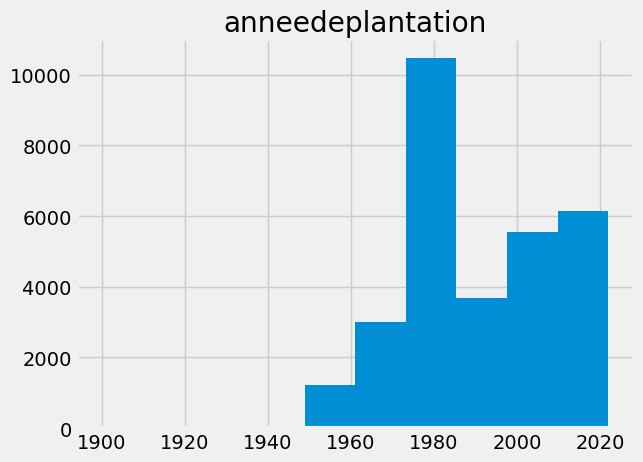

In [1106]:
#TOTAL BY THE YEAR
df_res.loc[:, ['anneedeplantation']].hist()

C:\Users\eduard.vlasov\AppData\Local\Temp\ipykernel_10968\2482591363.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_res["anneedeplantation"], color="b", label="Skewness : %.1f"%(df_res["anneedeplantation"].skew()))


<Axes: xlabel='anneedeplantation', ylabel='Density'>

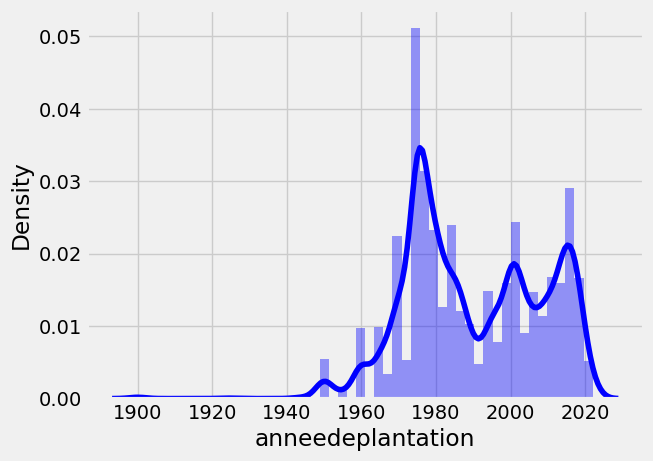

In [1107]:
sns.distplot(df_res["anneedeplantation"], color="b", label="Skewness : %.1f"%(df_res["anneedeplantation"].skew()))

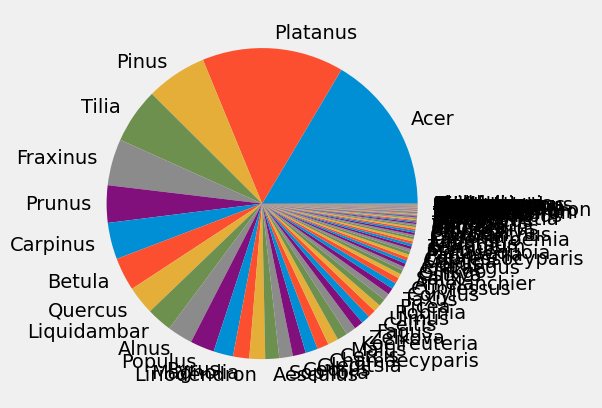

In [1108]:
#DOMINATION OF THE GENDER
data = df_res.genre_bota.value_counts().values
mylabels = df_res.genre_bota.value_counts().keys()


plt.pie(data, labels =mylabels)

plt.show() 

Text(0.5, 1.0, 'TOTAL PLANTED BY SOUS CATEGORIE')

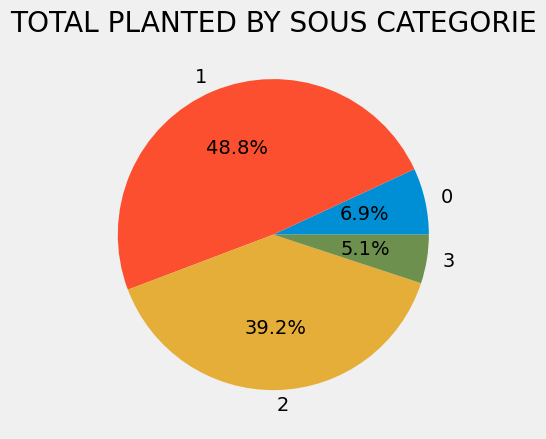

In [1109]:
#TOTAL PLANTED BY SOUS CATEGORIE
data = df_res.groupby('sous_categorie_desc')['anneedeplantation'].count()
plt.pie(data, labels =data.keys(), autopct='%1.1f%%')
plt.title('TOTAL PLANTED BY SOUS CATEGORIE')

Text(0.5, 1.0, 'TOTAL PLANTED BY AGE')

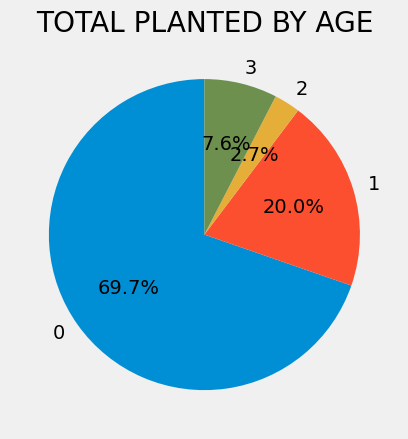

In [1110]:
#TOTAL PLANTED BY AGE
data = df_res.groupby('stadededeveloppement')['anneedeplantation'].count()
plt.pie(data,  labels = data.keys(), autopct='%1.1f%%', startangle=90)
plt.title('TOTAL PLANTED BY AGE')

In [1111]:
df_res.select_dtypes(include='number')

,elem_point_id,code,nom,sous_categorie,sous_categorie_desc,code_parent,adr_secteur,bien_reference,stadededeveloppement,anneedeplantation,hauteurarbre,lat,long
0,5259,11324,11324,151,2,175,5,11324,0,1975.0,15.0,45.175674,5.749421
1,1478,27796,27796,151,2,175,5,27796,0,1975.0,15.0,45.175689,5.749450
2,13139,4323,4323,174,1,1009,5,4323,0,1975.0,15.0,45.175403,5.748483
3,24132,7132,7132,174,1,1009,5,7132,0,1975.0,15.0,45.175424,5.748558
4,23970,15162,15162,174,1,625,5,15162,0,2009.0,5.0,45.177608,5.749357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31731,18164,27355,27355,151,2,915,6,27355,0,2011.0,15.0,45.166626,5.725421
31732,18170,27356,27356,151,2,215,6,27356,1,2004.0,15.0,45.166508,5.724994
31733,18173,27357,27357,151,2,544,6,27357,0,1976.0,15.0,45.164310,5.723866
31734,18179,27358,27358,151,2,917,6,27358,0,1976.0,15.0,45.160543,5.723836


Text(0.5, 1.0, 'DEPENDENCES')

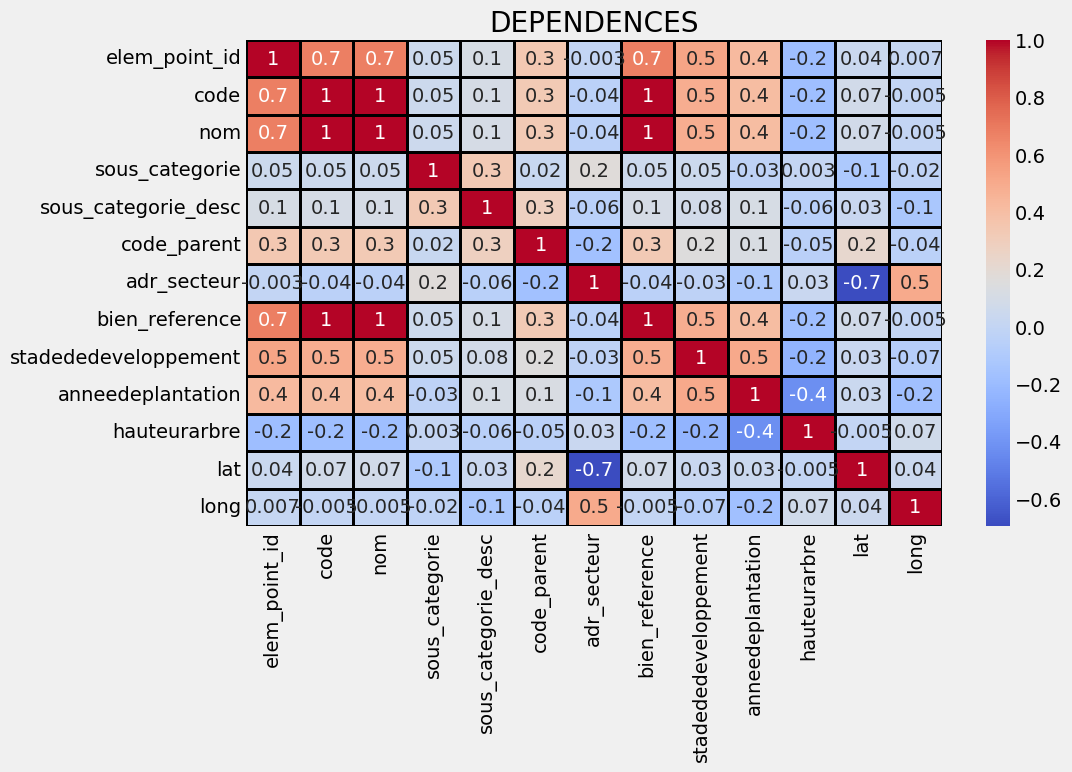

In [1112]:
plt.figure(figsize=(10,6))
dataplot = sns.heatmap(df_res.select_dtypes(include='number').corr(), annot=True, fmt='.1g', cmap= 'coolwarm', linecolor='black', linewidths=2)
plt.title('DEPENDENCES')

Text(0.5, 1.0, 'CONCENTRATION TREES BY THE COORDINATES')

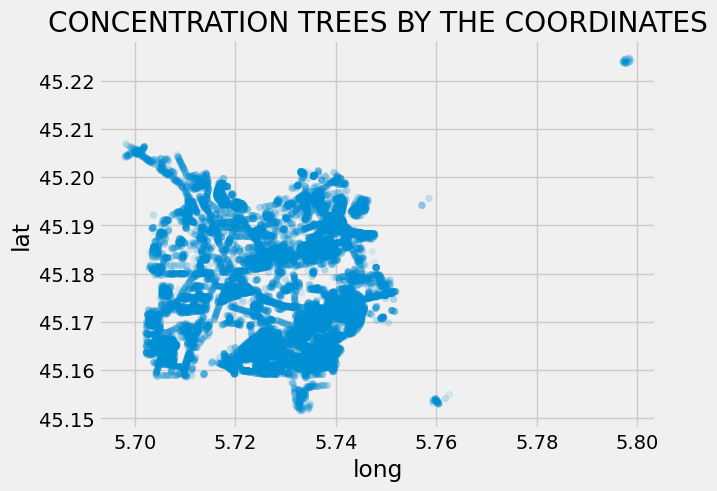

In [1113]:
df_res.plot(kind="scatter", x="long", y="lat", alpha=0.1)
plt.title('CONCENTRATION TREES BY THE COORDINATES')

### ITER 2

In [1115]:
#Utiliser des pipelines Scikit-Learn pour préparer les données pour les modèles d'apprentissage automatique
df_res

,elem_point_id,code,nom,sous_categorie,sous_categorie_desc,code_parent,code_parent_desc,adr_secteur,bien_reference,genre_bota,espece,stadededeveloppement,anneedeplantation,hauteurarbre,lat,long
0,5259,11324,11324,151,2,175,Av J O Poterne rond point,5,11324,Robinia,pseudoacacia,0,1975.0,15.0,45.175674,5.749421
1,1478,27796,27796,151,2,175,Av J O Poterne rond point,5,27796,Acer,campestre,0,1975.0,15.0,45.175689,5.749450
2,13139,4323,4323,174,1,1009,Av J O caisse d'épargne,5,4323,Fraxinus,americana,0,1975.0,15.0,45.175403,5.748483
3,24132,7132,7132,174,1,1009,Av J O caisse d'épargne,5,7132,Fraxinus,americana,0,1975.0,15.0,45.175424,5.748558
4,23970,15162,15162,174,1,625,R M Riollet cité rouge,5,15162,Prunus,avium,0,2009.0,5.0,45.177608,5.749357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31731,18164,27355,27355,151,2,915,Allée des Romantiques pair,6,27355,Betula,utilis,0,2011.0,15.0,45.166626,5.725421
31732,18170,27356,27356,151,2,215,Ave La Bruyère pair,6,27356,Pyrus,calleryana,1,2004.0,15.0,45.166508,5.724994
31733,18173,27357,27357,151,2,544,R Pupin Ma Oisans à R François,6,27357,Platanus,acerifolia,0,1976.0,15.0,45.164310,5.723866
31734,18179,27358,27358,151,2,917,R Pupin du tunnel à Esmonin,6,27358,Platanus,acerifolia,0,1976.0,15.0,45.160543,5.723836


In [1117]:
features = ['sous_categorie', 'sous_categorie_desc','adr_secteur', 'bien_reference', 'stadededeveloppement','hauteurarbre', 'lat', 'long']
X = df_res.loc[:, features]
y = df_res.loc[:, ['anneedeplantation']]

In [1118]:
#SELECT TRAIN AND EST DATA

##!!!!!!!!!!!!!!!!!!! NEVER TOUCH TEST DATA !!!!!!!!!!!!!!!!!!!!!!

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

print(f'train subset of {len(X_train)} examples which are {len(X_train)/len(df_res)*100} % of all DATA')
print(f'test subset of {len(X_test)} examples which are {len(X_test)/len(df_res)*100} % of all DATA')


train subset of 23002 examples which are 79.99860884081662 % of all DATA
test subset of 5751 examples which are 20.00139115918339 % of all DATA


#### DecisionTreeRegressor

In [1119]:
#REGRESSION !!!DIFF DEPTH!!!

# List of values to try for max_depth:
max_depth_range = list(range(1, 25))

# List to store the average RMSE for each value of max_depth:
r2_test_list = []

r2_train_list = []

for depth in max_depth_range:
    
    reg = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 0)
    reg.fit(X_train, y_train)    
    
    score = reg.score(X_test, y_test)
    r2_test_list.append(score)
    
    # Bad practice: train and test the model on the same data
    score = reg.score(X_train, y_train)
    r2_train_list.append(score)

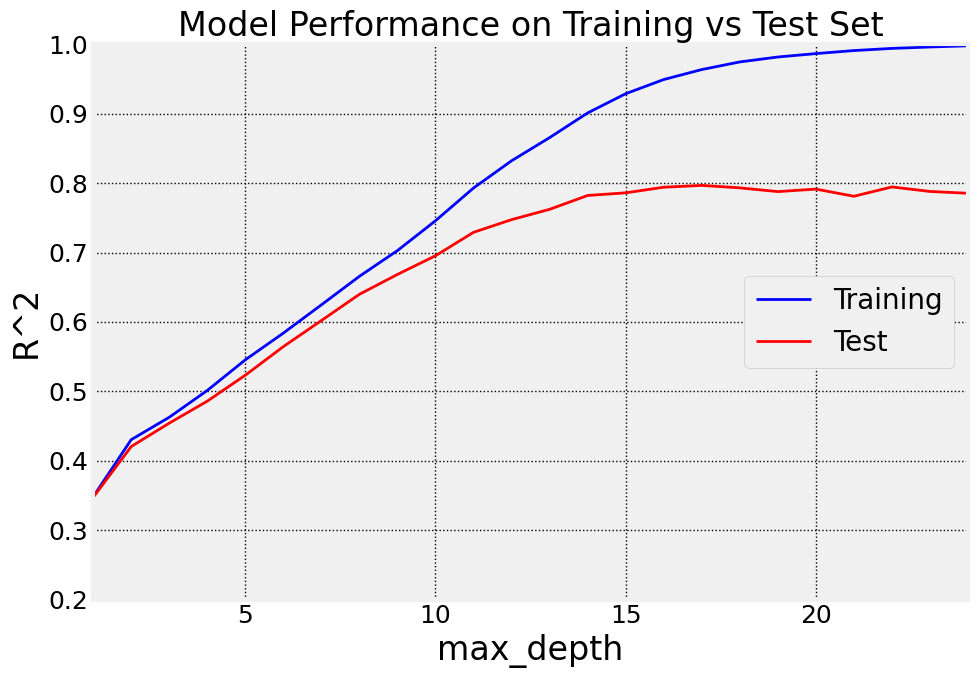

In [1123]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,7), facecolor = 'white');

ax.plot(max_depth_range,
        r2_train_list,
        lw=2,
        color='b',
        label = 'Training')

ax.plot(max_depth_range,
        r2_test_list,
        lw=2,
        color='r',
        label = 'Test')

ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('R^2', fontsize = 24)
ax.set_ylim(.2,1)

ax.legend(loc = 'center right', fontsize = 20, framealpha = 1)


ax.set_title('Model Performance on Training vs Test Set', fontsize = 24)


temp = ax.get_xlim()
temp1 = ax.get_ylim()

fig.tight_layout()
#fig.savefig('images/max_depth_vs_R2_Best_Model.png', dpi = 300)

In [1133]:
#FIT
reg = DecisionTreeRegressor(max_depth = 6, random_state = 0)
reg.fit(X_train, y_train)

#PREDICTION TEST
y_pred = reg.predict(X_test)
score = reg.score(X_test, y_test)
print(score)

0.5644721760514144


In [1134]:
df_predict_trees = pd.DataFrame({'Actual': y_test.anneedeplantation.to_numpy(), 'Predicted': y_pred})
df_predict_trees

,Actual,Predicted
0,1960.0,1982.975361
1,1960.0,1967.287129
2,1977.0,1982.975361
3,1975.0,1987.045249
4,2003.0,1985.366337
...,...,...
5746,1999.0,1986.409165
5747,1976.0,1986.409165
5748,1975.0,1975.913170
5749,1970.0,1985.366337


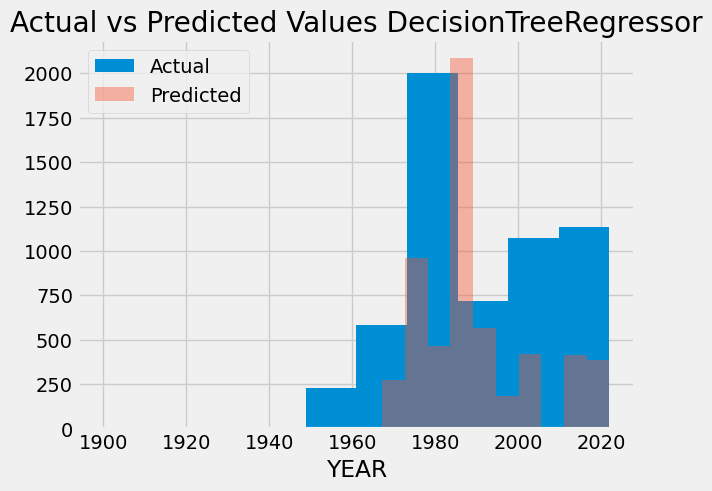

In [1135]:
plt.hist(df_predict_trees['Actual'], label='Actual')
plt.hist(df_predict_trees['Predicted'], label='Predicted', alpha=0.4)

plt.xlabel('YEAR')
plt.title('Actual vs Predicted Values DecisionTreeRegressor')
plt.legend()

plt.show()

#### Random Forest Regression

In [1177]:
features = ['sous_categorie', 'sous_categorie_desc','adr_secteur', 'bien_reference', 'stadededeveloppement','hauteurarbre', 'lat', 'long']
X = df_res.loc[:, features]
y = df_res.loc[:, ['anneedeplantation']]

In [1178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

print(f'train subset of {len(X_train)} examples which are {len(X_train)/len(df_res)*100} % of all DATA')
print(f'test subset of {len(X_test)} examples which are {len(X_test)/len(df_res)*100} % of all DATA')

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

train subset of 23002 examples which are 79.99860884081662 % of all DATA
test subset of 5751 examples which are 20.00139115918339 % of all DATA
Training Features Shape: (23002, 8)
Training Labels Shape: (23002, 1)
Testing Features Shape: (5751, 8)
Testing Labels Shape: (5751, 1)


In [1179]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)

rf.fit(X_train, y_train)

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\base.py:1215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=0)

In [1180]:
# Calculate the mean absolute error (mae)

predictions = rf.predict(X_test)
errors = abs(predictions - y_test.anneedeplantation.to_numpy())
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 2.68 degrees.


In [1182]:
# Calculate mean absolute percentage error (MAPE)

mape = 100 * (errors / y_test.anneedeplantation.to_numpy())

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 99.87 %.


In [1185]:
df_predict_RFR = pd.DataFrame({'Actual': y_test.anneedeplantation.to_numpy(dtype=list), 'Predicted': predictions})
df_predict_RFR

,Actual,Predicted
0,1960.0,1977.66
1,1960.0,1968.32
2,1977.0,1977.70
3,1975.0,1976.43
4,2003.0,2002.89
...,...,...
5746,1999.0,1999.00
5747,1976.0,1976.00
5748,1975.0,1978.60
5749,1970.0,1972.90


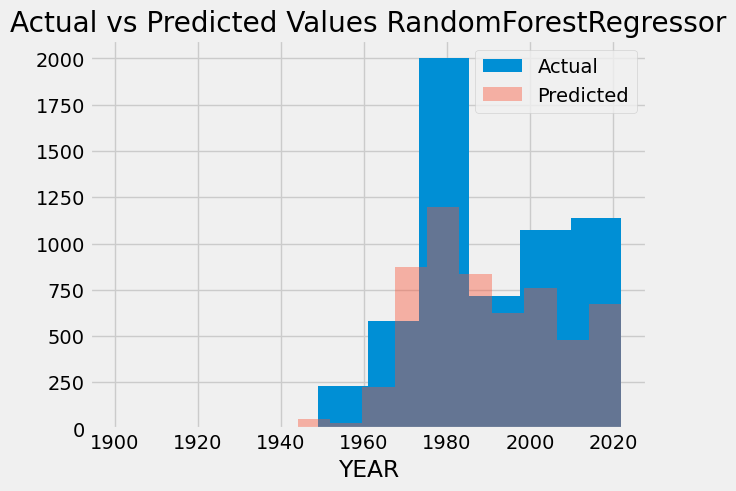

In [1143]:
plt.hist(df_predict_RFR['Actual'], label='Actual')
plt.hist(df_predict_RFR['Predicted'], label='Predicted', alpha=0.4)

plt.xlabel('YEAR')
plt.title('Actual vs Predicted Values RandomForestRegressor')
plt.legend()


#### Linear Regression

In [1245]:
df_numeric = df_res.select_dtypes(include='number')

In [1246]:
X  = df_numeric.loc[:, df_numeric.columns !=  'anneedeplantation']
y = df_numeric.loc[:, ['anneedeplantation']]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

In [1188]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [1247]:
r_sq = model.score(X_train, y_train)
print(r_sq)
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

0.418834699923491
intercept: [5177.21091497]
slope: [[ 2.22641817e-04  6.64837598e-05  6.64837752e-05 -5.30130098e-02
   1.59842065e+00 -4.96137964e-05 -4.01960320e-01  6.64837754e-05
   6.14571886e+00 -9.63112390e-01 -5.14934955e+01 -1.48747813e+02]]


In [1218]:
predictions = model.predict(X_test)

In [1219]:
df_predict_LINEAR = pd.DataFrame({'Actual': y_test.anneedeplantation.to_numpy(), 'Predicted': predictions.ravel()})
df_predict_LINEAR

,Actual,Predicted
0,1960.0,1965.221786
1,1960.0,1970.534451
2,1977.0,1981.202751
3,1975.0,1986.850313
4,2003.0,1987.127606
...,...,...
5746,1999.0,1984.464332
5747,1976.0,1983.004624
5748,1975.0,1979.161824
5749,1970.0,1988.005091


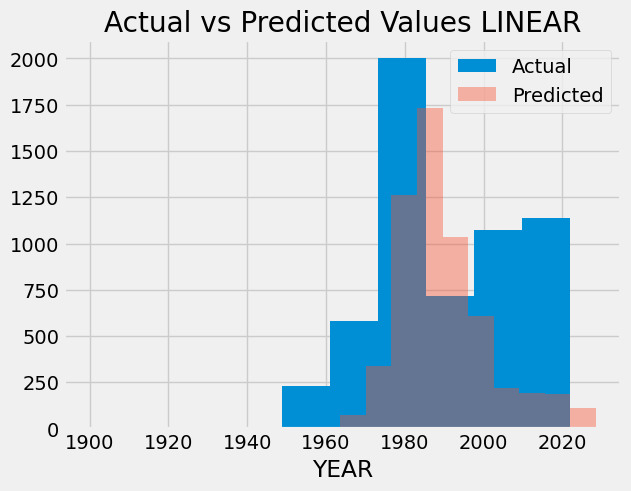

In [1201]:
plt.hist(df_predict_LINEAR['Actual'], label='Actual')
plt.hist(df_predict_LINEAR['Predicted'], label='Predicted', alpha=0.4)

plt.xlabel('YEAR')
plt.title('Actual vs Predicted Values LINEAR')
plt.legend()

plt.show()

C:\Users\eduard.vlasov\AppData\Local\Temp\ipykernel_10968\279152185.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
C:\Users\eduard.vlasov\AppData\Local\Temp\ipykernel_10968\279152185.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe

<Axes: ylabel='Density'>

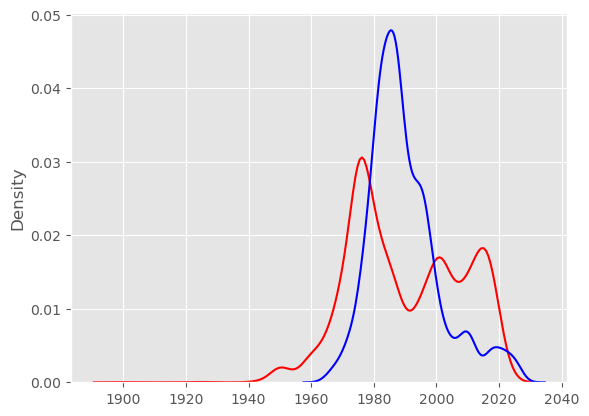

In [1252]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(predictions, hist=False, color="b", label="Fitted Values" , ax=ax1)
